<a id="title_ID"></a>
# Example satellite trail detection in WFC/ACS data with findsat_mrt

This notebook provides examples of how to find satellite trails in ACS/WFC data. The tools presented here should be applicable to any imaging data.

### Table of Contents

[Introduction](#intro_ID) <br>
[Imports and Setup](#imports) <br>
[Example 1: Find trails in an FLC image](#example1) <br>
[Example 2: Find trails in a DRC image](#example2) <br>
[Example 3: Quick run on a DRC image](#example3)<br>
[About this Notebook](#about_ID) 

<a id="intro_ID"></a>
## Introduction

Despite being in orbit, HST imaging data still suffers from contamination by artificial satellites that can compromise science data unless they are identified and masked. This notebook presents examples of how to identify satellite trails in ACS/WFC data. The routine is also effective at identifying other linear features duch as <a href="https://hst-docs.stsci.edu/acsdhb/files/60243156/60243162/1/1567011208101/acs_Ch46.2.jpg">diffraction spikes</a> and <a href="https://hst-docs.stsci.edu/acsdhb/chapter-4-acs-data-processing-considerations/4-5-image-anomalies">glint</a> (see <a href="https://hst-docs.stsci.edu/acsdhb/chapter-4-acs-data-processing-considerations/4-5-image-anomalies">Section 4.5 of the ACS DHB<a/> for further information). 

A full description of the algorithm is provided in ACS ISR 2022-08. To briefly summarize, the Median Radon Transform (MRT) is calculated for an input image and used to identify linear signals in the data. The MRT is similar to the standard <a href="https://en.wikipedia.org/wiki/Radon_transform">Radon Transform</a> except that it calculates the median of the data along all possible paths through an image, rather than the sum. This alteration makes the algorithm more robust against false signals from localized sources (e.g., stars, galaxies) but still very sensitive to persistence linear features, even well-below the background noise level. 

Additional post-processing is done to filter out spurious detections, primarily eliminating them based on trail S/N, width, and persistence across the image. These parameters, especially the maximum allowed trail width, are tuned for ACS/WFC data and may be different for images from other instruments. Once the final set of trails is identified and characterized, a mask can be created.

The routine provides numerous ways of visualizing the results, as will be demonstrated below.

<a id="imports"></a>
## Imports and Setup

Set your working directory and import the needed packages with the following

In [1]:
#check your own working directory
import os
print('Current working directory is {}'.format(os.getcwd()))

#update as needed with
#os.chdir('/Users/dstark/acs_work/satellite_trails/findsat_mrt/')


Current working directory is /Users/dstark/acs_work/acs-notebook/acs_findsat_mrt


In [2]:
#import modules and setup
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.nddata import bitmask
import numpy as np
import ccdproc
from astroquery.mast import Observations
from acstools.findsat_mrt import trailfinder

#These are optional configurations
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "serif"

<a id="example1"></a>

## Example 1: Finding trails in an FLC image

FLC images are individual exposures processed by the CALACS pipeline. The data contain two chips, but we only analyze one here. 

We start by reading in an image and doing some pre-processing to remove bad pixels and make the image a bit small (to speed up the calculation of the MRT)

Download the example data from <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/jc8m32j5q_flc.fits">here</a> and put it in your working directory.

In [5]:
#Read in the image files and header information
image_file = 'jc8m32j5q_flc.fits'
ext = 4 #ACS image data are in extensions 1 or 4, we'll just use 1 for now
with fits.open(image_file) as h:
    image = h[ext].data #image data
    dq=h[ext+2].data #data quality bitmasks
    
    header = h[0].header #primary header
    image_header = h[1].header #image header


In [6]:
#make a mask for bad pixels. We're ignoring cosmic rays here because routines to make them often partially mask trails
mask = bitmask.bitfield_to_boolean_mask(dq,ignore_flags=[4096,8192,16384])
image[mask == True]=np.nan

#Subtract the background from the image. Here we just do a simple median
image = image-np.nanmedian(image)

In [7]:
#the MRT is computationally demanding and WFC images are big. To help things a bit, let's rebin the images.
image_rebin=ccdproc.block_reduce(image, 4,func=np.nansum)

We now set up trailfinder inside findsat_mrt. Many of the parameters in the call below are optional (set to their current values by default) but we show them to illustrate the setup. I'm explicitly defining the image header keys to save. These can be useful later when analyzing trail population properties.

In [8]:
#Now we can set up findsat_mrt
s=trailfinder(image=image_rebin,
            header=header,
            image_header=image_header,
            save_image_header_keys = ['ROOTNAME','CCDCHIP','CRPIX1','CRPIX2','CRVAL1','CRVAL2','ORIENTAT','RA_APER','DEC_APER','PA_APER'],
            threads=8,
            plot=False,
            threshold=5,
            max_width=75,
            check_persistence=True,
            min_persistence=0.5,
            output_root='test')

Before we actually run anything, let's plot the image. You should see two satellite trails in this example.

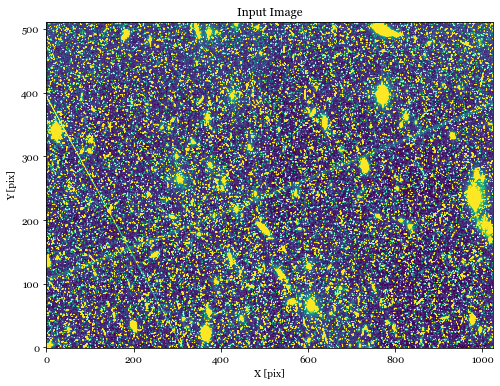

In [9]:
s.plot_image()

#We e can see the satellite trail crossing the left side of the image

Next we run the Median Radon Transform. This step can take some time depending on the image size and number of threads being used

In [10]:
#let's calculate the Median Radon Transform (MRT) for this image. This can take a while depending on your image 
#size and number of threads
s.run_mrt()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 threads
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/

(360, 2, 1449)


/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/acstools/findsat_mrt.py:252: RuntimeWarning: divide by zero encountered in true_divide
  self.mrt_err = 1.25*self._image_stddev/np.sqrt(self.length) #error on median ~ 1.25x error on mean


Now we will plot the MRT. You may be able to spot the signals from the satellite trails as two somewhat wide point-like sources.

<AxesSubplot:title={'center':'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

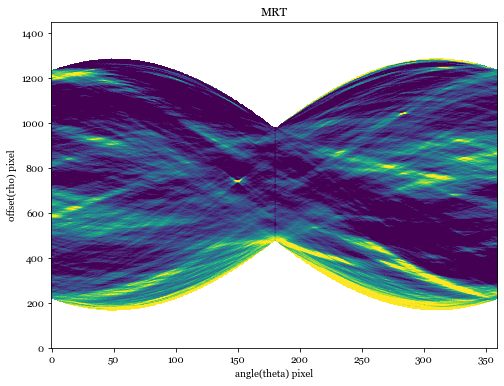

In [11]:
s.plot_mrt()

We next run the source finder on the MRT. Depending on the settings. This can pick up a lot more than the actual trails. There are additional steps we'll take later to filter these false detections out.

In [12]:
s.find_mrt_sources()
s.source_list

INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:3 sources found
INFO:findsat_mrt:Using kernel /Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:7 sources found
INFO:findsat_mrt:Using kernel /Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:24 sources found


id,xcentroid,ycentroid,fwhm,roundness,pa,max_value,flux,mag,theta,rho,endpoints,status
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,"float64[2,2]",int64
1,2.556921852638252,585.7124524421566,11.208145112147267,0.8795779421924734,89.80076262921622,11.818336083671394,906.817181937332,-7.393799350840318,1.278460926319126,-138.28754755784337,367.4760116858094 .. 511.0,0
2,149.46243376533872,738.6182271814416,9.339687150006457,0.7056270720611201,85.67469810530051,31.50620683625238,1159.3522038963445,-7.66053847984031,74.73121688266936,14.618227181441625,0.0 .. 379.97795270196525,0
3,282.7333422953691,1037.6218786390145,7.811912038038552,0.8221626070008908,69.76825298371844,121.8596644516795,897.9915439341946,-7.3831806177261425,141.36667114768454,313.62187863901454,-0.0 .. 0.0,0
4,357.0279517793017,241.14516765086637,11.945708773909256,0.9227416251525582,89.3436189323143,11.89948485834648,753.7146128960259,-7.1930173384600495,178.51397588965085,-482.85483234913363,987.8891427894395 .. 0.0,0
5,325.26899850459347,265.687527881605,11.80021494714486,0.76454693301914,95.64644914102034,25.33490979686316,1827.0660681341817,-8.154385630159283,162.63449925229673,-458.312472118395,911.7999523191393 .. 155.41003465452695,0
9,357.10786934958185,860.7569375528348,11.782333052929335,0.9204633111250182,89.41537050381578,10.636501268810429,694.9201978803841,-7.104837336618828,178.55393467479092,136.75693755283476,368.2496625574116 .. 0.0,0
13,310.3296205566686,296.8507733104668,12.135467897793857,0.7778084159740938,94.86979094218843,17.887041312650094,1856.071756116492,-8.171486905303873,155.1648102783343,-427.1492266895332,863.9295870634014 .. 167.2946351876667,0
15,236.9390264371301,379.5387924008449,11.706150594024434,0.778809778016174,98.99645978778047,12.705735072369007,896.2565251998369,-7.38108082642595,118.46951321856506,-344.4612075991551,762.9387254276179 .. 369.9773679446612,0
16,207.07172582840704,423.8899951799956,12.204965257662993,0.7729422121570554,95.82979561985644,16.51751981484534,1354.1802513188682,-7.82919118994029,103.53586291420352,-300.1100048200044,732.418606321484 .. 441.04518492257534,0


We can plot the MRT again and it will overlay the sources. There are a lot, but not all are what we want.

<AxesSubplot:title={'center':'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

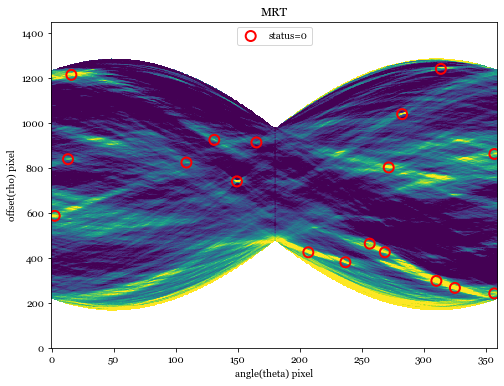

In [13]:
s.plot_mrt(show_sources=True)

We filter the sources further based on their S/N, width, and persistence. The default parameters (namely width) have been chosen for ACS data. It's possible different defaults will be better for different imaging data.

In [14]:
s.filter_sources()
#some extra columns have been added to the source list
s.source_list

INFO:findsat_mrt:Filtering sources...
INFO:findsat_mrt:Min SNR : 5
INFO:findsat_mrt:Max Width: 75
INFO:findsat_mrt:Min Length: 25
INFO:findsat_mrt:Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of feature: 37.656043047368186
INFO:utils_findsat_mrt:baseline noise: 8.046853488802926
INFO:utils_findsat_mrt:snr of feature = 3.6795984417718053
INFO:utils_findsat_mrt:width of feature = 47.17828967584845
INFO:utils_findsat_mrt:amplitude of feature: 94.83667587274397
INFO:utils_findsat_mrt:baseline noise: 7.189818348315032
INFO:utils_findsat_mrt:snr of feature = 12.190413342636035
INFO:utils_findsat_mrt:width of feature = 12.902805804864784
INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
INFO:utils_findsat_mrt:Section size for persistence check: 100
INFO:utils_findsat_mrt:Checking persistence, step 1 of 10
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWar

/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
INFO:utils_findsat_mrt:amplitude of feature: 567.7246356991848
INFO:utils_findsat_mrt:baseline noise: 12.732827847613358
INFO:utils_findsat_mrt:snr of feature = 43.58747440032334
INFO:utils_findsat_mrt:width of feature = 2.621875607624247
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 43.58747440032334, 2.621875607624247, 245.54889828121986
INFO:utils_findsat_mrt:Checking persistence, step 3 of 5
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
INFO:utils_findsat_mrt:amplitude of feature: 541.3906888667176
INFO:utils_findsat_mrt:baseline noise: 15.782889352410674
INFO:utils_findsat_mrt:snr of feature

/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
INFO:utils_findsat_mrt:amplitude of feature: 34.379365789921145
INFO:utils_findsat_mrt:baseline noise: 7.624307834304843
INFO:utils_findsat_mrt:snr of feature = 3.509178608349794
INFO:utils_findsat_mrt:width of feature = 177.6389472635409
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
INFO:utils_findsat_mrt:amplitude of feature: 78.45912467785791
INFO:utils_findsat_mrt:baseline noise: 6.559554268492634
INFO:utils_findsat_mrt:snr of feature = 10.96104513605733
INFO:utils_findsat_mrt:width of feature = 108.8209843138012
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/li

id,xcentroid,ycentroid,fwhm,roundness,pa,max_value,flux,mag,theta,rho,endpoints,status,mean flux,width,snr,persistence
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,"float64[2,2]",int64,float64,float64,float64,float64
1,2.556921852638252,585.7124524421566,11.208145112147267,0.8795779421924734,89.80076262921622,11.818336083671394,906.817181937332,-7.393799350840318,1.278460926319126,-138.28754755784337,367.4760116858094 .. 511.0,0,24.12035993770153,47.17828967584845,3.6795984417718053,0.0
2,149.46243376533872,738.6182271814416,9.339687150006457,0.7056270720611201,85.67469810530051,31.50620683625238,1159.3522038963445,-7.66053847984031,74.73121688266936,14.618227181441625,0.0 .. 379.97795270196525,2,85.07198506119805,12.902805804864784,12.190413342636035,1.0
3,282.7333422953691,1037.6218786390145,7.811912038038552,0.8221626070008908,69.76825298371844,121.8596644516795,897.9915439341946,-7.3831806177261425,141.36667114768454,313.62187863901454,-0.0 .. 0.0,2,433.64981506129465,4.006194751109547,50.51266311092556,1.0
4,357.0279517793017,241.14516765086637,11.945708773909256,0.9227416251525582,89.3436189323143,11.89948485834648,753.7146128960259,-7.1930173384600495,178.51397588965085,-482.85483234913363,987.8891427894395 .. 0.0,0,44.465379379504114,197.94015183916122,10.57818071700412,0.0
5,325.26899850459347,265.687527881605,11.80021494714486,0.76454693301914,95.64644914102034,25.33490979686316,1827.0660681341817,-8.154385630159283,162.63449925229673,-458.312472118395,911.7999523191393 .. 155.41003465452695,0,48.620455794374394,94.39493546033282,11.237235230729203,0.0
9,357.10786934958185,860.7569375528348,11.782333052929335,0.9204633111250182,89.41537050381578,10.636501268810429,694.9201978803841,-7.104837336618828,178.55393467479092,136.75693755283476,368.2496625574116 .. 0.0,0,15.515560231208504,92.94445069519278,2.3265610931181073,0.0
13,310.3296205566686,296.8507733104668,12.135467897793857,0.7778084159740938,94.86979094218843,17.887041312650094,1856.071756116492,-8.171486905303873,155.1648102783343,-427.1492266895332,863.9295870634014 .. 167.2946351876667,0,51.530863531896586,87.79607612449169,8.94381231697917,0.0
15,236.9390264371301,379.5387924008449,11.706150594024434,0.778809778016174,98.99645978778047,12.705735072369007,896.2565251998369,-7.38108082642595,118.46951321856506,-344.4612075991551,762.9387254276179 .. 369.9773679446612,0,31.833801563158268,19.69586653395507,4.2955162563570894,0.0
16,207.07172582840704,423.8899951799956,12.204965257662993,0.7729422121570554,95.82979561985644,16.51751981484534,1354.1802513188682,-7.82919118994029,103.53586291420352,-300.1100048200044,732.418606321484 .. 441.04518492257534,0,36.43275731714434,31.79392634851007,4.557144018556817,0.0


Several columns have been added to the source list that characterize the observed streak. Also, the status array has values of 0, 1, and 2 now (it just had 0 before). Status=2 are sources that passed all filtering stages (checks for SNR and width, then persistence). Status=1 are sources that passed the first filtering stage, but not the second. And status=0 are sources that did not pass the filtering steps.

The plot command will automatically overplot the different statuses

<AxesSubplot:title={'center':'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

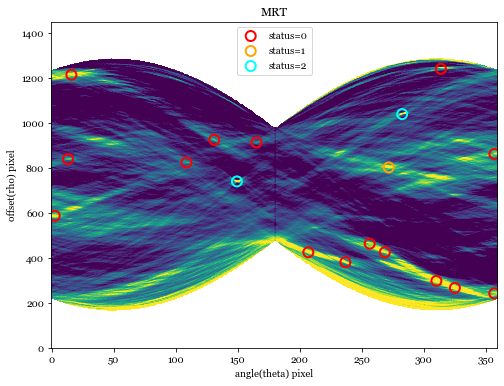

In [15]:
s.plot_mrt(show_sources=True)

Now we can make the mask itself. We make two types of masks, one a simple boolean mask, and one a segementation mask where pixels corresponding to each streak are assigned the its ID number. We can also overlay the mask on top of the image to make sure it makes sense.

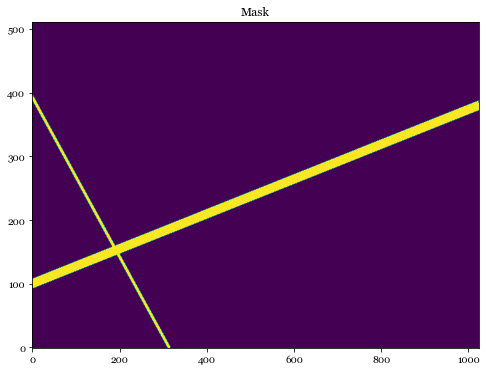

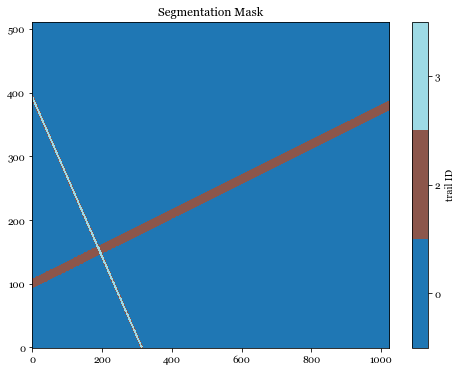

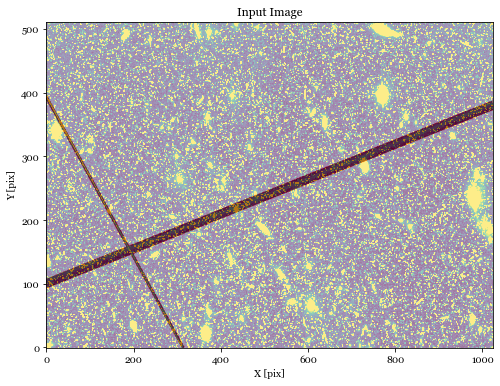

In [16]:
s.make_mask(plot=True)
s.plot_image(overlay_mask=True)

We can save the results now. You have the optional of saving the catalog, mask, MRT, and a diagnostic image that shows the results. In this example we'll just save everything.

In [17]:
os.getcwd()

'/Users/dstark/acs_work/acs-notebook/acs_findsat_mrt'

In [18]:
s.save_output(save_mask=True,save_mrt=True,save_diagnostic=True,save_catalog=True,output_dir='./',root = 'flc_test')

Keep in mind that this mask is applicable to the rebinned image. To convert it into a mask that can be applied to the original image, we need to resample it

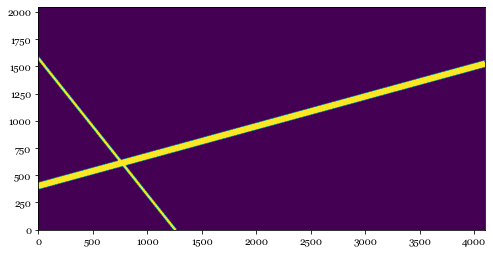

In [19]:
full_mask = ccdproc.block_replicate(s.mask, 4, conserve_sum=False)
fig,ax=plt.subplots()
ax.imshow(full_mask,origin='lower')

<a id="example2"></a>
## Example 2: Finding trails in a DRC image

Applying our code to a DRC image (that shows both chips together) can increase sensitivity by increasing the number of pixels over which we search for trails. The drc files also remove the distortion in the original flc files (though this does not appear to create signficant curvature to trails). 

There are no DQ arrays for the drc files, so we ignore the pre-processing steps that incorporated those.

Download the DRC file <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits">here</a> and move it into your working directory.

In [20]:
#Read in the image files and header information
image_file = 'hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits'
ext = 1 #ACS image data are in extensions 1 or 4, we'll just use 1 for now
with fits.open(image_file) as h:
    image = h[ext].data #image data
    wht = h[ext+1].data
    image = image*wht #wht is effective exposure time, so this turns it into counts
    variance = image #just assumimg very simplistic poisson stats for now
    
    header = h[0].header #primary header
    image_header = h[1].header #image header

In [21]:
#Flag anything with wht == 0 as bad
image[wht == 0]=np.nan
variance[wht == 0] = np.nan

#Subtract the background from the image. Here we just do a simple median
median = np.nanmedian(image)
image = image-np.nanmedian(image)

In [22]:
#the MRT is computationally demanding and WFC images are big. To help things a bit, let's rebin the images.
image_rebin=ccdproc.block_reduce(image, 4,func=np.nansum)

Setting up findsat_mrt is essentially the same as example 1 now. We'll use the default settings. In fact, about all the steps from here on out are the same.

In [23]:
#Now we can set up findsat_mrt
s2=trailfinder(image=image_rebin)

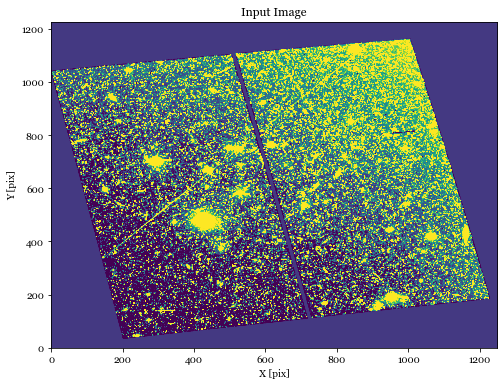

In [24]:
#we can do a quick plot of our image to make sure things look ok
s2.plot_image()

In [25]:
s2.run_mrt(threads=8)

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 threads
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/

(360, 2, 1768)


/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/acstools/findsat_mrt.py:252: RuntimeWarning: divide by zero encountered in true_divide
  self.mrt_err = 1.25*self._image_stddev/np.sqrt(self.length) #error on median ~ 1.25x error on mean


<AxesSubplot:title={'center':'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

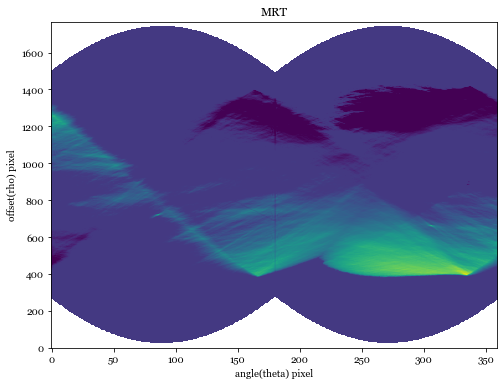

In [26]:
#let's plot the MRT
s2.plot_mrt()

This example has a clear gradient in the background due to the cluster. This causes some large scale variation in the RT, but you can see the "point source" signals from the satellite trails around x,y = 90,700 and x,y = 300,700. Now we'll see if we can pull them out.

In [27]:
s2.find_mrt_sources()
s2.source_list

INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width15.fits
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:324: RuntimeWarning: invalid value encountered in true_divide
  return moments / self.moments[:, 0, 0][:, np.newaxis, np.newaxis]
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:315: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(self.flux)
INFO:findsat_mrt:33 sources found
INFO:findsat_mrt:Using kernel /Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width7.fits
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:324: RuntimeWarning: invalid value encountered in true_divide
  return moments / se

id,xcentroid,ycentroid,fwhm,roundness,pa,max_value,flux,mag,theta,rho,endpoints,status
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,"float64[2,2]",int64
1,269.0260097049431,394.8231282942499,9.795213884421386,0.6247457788694859,88.65910082208853,38.26541739431731,5055.840711832564,-9.25948345676677,134.51300485247154,-488.6768717057501,698.0330231040379 .. 684.3203809020333,0
2,166.1349163720854,397.55436087897584,9.14018911823346,0.6452723000842807,90.86527575644224,45.593910316747625,5361.625230369253,-9.323241135423176,83.0674581860427,-485.94563912102416,0.0 .. 1178.457293375882,0
3,333.79965473681034,402.61843337934636,9.714718876377358,0.6647340346949101,88.7818327986673,73.2467692490824,9063.36925290822,-9.893224185123508,166.89982736840517,-480.88156662065364,975.5792540121622 .. 51.060380692732,0
4,234.8466319422198,423.25129513342523,10.838624546690847,0.7581003106284379,97.655833970557,32.66366923065476,4029.9796468140476,-9.013257131916873,117.4233159711099,-460.24870486657477,442.40191540457346 .. 807.4827465756248,0
5,154.2921099489742,442.1528583422628,12.860529662769697,0.7886155169856958,91.70827835762547,38.86446075383694,6630.116593215215,-9.55380291427919,77.1460549744871,-441.3471416577372,0.0 .. 1208.192819100354,0
7,222.75765325816823,459.6736352688177,12.016861784578566,0.8828515556220292,90.97214169641116,31.735413288258343,3297.46674318612,-8.795451060338587,111.37882662908412,-423.8263647311823,221.26190795494327 .. 823.6719078821031,0
8,356.5404134256128,507.70571742210103,12.582842477635172,0.8974048069086369,89.71744150441927,42.72344962209591,5084.821230039694,-9.265689221970865,178.2702067128064,-375.79428257789897,981.9531550965685 .. 0.0,0
9,135.00481048445187,527.0268718665202,12.898369551586747,0.7970970513002568,90.4241690889935,32.628683717119834,4512.381880839961,-9.136014616691035,67.50240524222593,-356.4731281334798,0.0 .. 1226.0,0
10,356.5524166497814,566.3336301138331,12.548005604779126,0.8986735084749934,90.61163232879363,38.77366674853006,4722.757499641974,-9.185489115862586,178.2762083248907,-317.1663698861669,923.3617802050672 .. 0.0,0


In [28]:
print(s2.source_list)


 id     xcentroid          ycentroid             fwhm            roundness      ...       theta                rho                        endpoints                status
--- ------------------ ------------------ ------------------ ------------------ ... ------------------ ------------------- --------------------------------------- ------
  1  269.0260097049431  394.8231282942499  9.795213884421386 0.6247457788694859 ... 134.51300485247154  -488.6768717057501  698.0330231040379 .. 684.3203809020333      0
  2  166.1349163720854 397.55436087897584   9.14018911823346 0.6452723000842807 ...   83.0674581860427 -485.94563912102416                0.0 .. 1178.457293375882      0
  3 333.79965473681034 402.61843337934636  9.714718876377358 0.6647340346949101 ... 166.89982736840517 -480.88156662065364    975.5792540121622 .. 51.060380692732      0
  4  234.8466319422198 423.25129513342523 10.838624546690847 0.7581003106284379 ...  117.4233159711099 -460.24870486657477 442.40191540457346 .. 807.4

<AxesSubplot:title={'center':'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

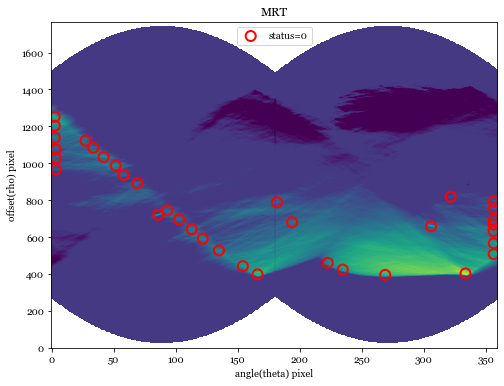

In [29]:
s2.plot_mrt(show_sources=True)

It's clearly shredding those large-scale features quite a bit, but we'll try to filter these out.

INFO:findsat_mrt:Filtering sources...
INFO:findsat_mrt:Min SNR : 5
INFO:findsat_mrt:Max Width: 75
INFO:findsat_mrt:Min Length: 25
INFO:findsat_mrt:Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of feature: 39.93435356791937
INFO:utils_findsat_mrt:baseline noise: 14.253259286355116
INFO:utils_findsat_mrt:snr of feature = 1.8017699506911518
INFO:utils_findsat_mrt:width of feature = 106.3527201363072
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
INFO:utils_findsat_mrt:amplitude of feature: 70.67425481371215
INFO:utils_findsat_mrt:baseline noise: 9.616954299352123
INFO:utils_findsat_mrt:snr of feature = 6.348922810049472
INFO:utils_findsat_mrt:width of feature = 101.50473319457274
INFO:utils_findsat_mrt:amplitude of feature: 113.6831096079471
INFO:utils_findsat_mrt:baselin

INFO:utils_findsat_mrt:amplitude of feature: 96.25519280396553
INFO:utils_findsat_mrt:baseline noise: 20.713582012171155
INFO:utils_findsat_mrt:snr of feature = 3.6469602769529024
INFO:utils_findsat_mrt:width of feature = 9.93277614526528
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 3.6469602769529024, 9.93277614526528, 250.4062643240319
INFO:utils_findsat_mrt:Checking persistence, step 12 of 13
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
INFO:utils_findsat_mrt:amplitude of feature: 67.45655284521261
INFO:utils_findsat_mrt:baseline noise: 7.464968919772193
INFO:utils_findsat_mrt:snr of feature = 8.0364144271978
INFO:utils_findsat_mrt:width of feature = 7.924912225710898
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 8.0364144271978, 7.924912225710898, 250.68807520780297
INFO:utils_findsat_mrt:Checking persiste

INFO:utils_findsat_mrt:Checking persistence, step 10 of 14
INFO:utils_findsat_mrt:amplitude of feature: 357.6943965584452
INFO:utils_findsat_mrt:baseline noise: 17.693862975226008
INFO:utils_findsat_mrt:snr of feature = 19.215732260347533
INFO:utils_findsat_mrt:width of feature = 3.35922295483266
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 19.215732260347533, 3.35922295483266, 252.4850662031017
INFO:utils_findsat_mrt:Checking persistence, step 11 of 14
INFO:utils_findsat_mrt:amplitude of feature: 532.5769733709046
INFO:utils_findsat_mrt:baseline noise: 28.52459770662845
INFO:utils_findsat_mrt:snr of feature = 17.670797002937086
INFO:utils_findsat_mrt:width of feature = 2.932410169205582
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 17.670797002937086, 2.932410169205582, 253.1250693639333
INFO:utils_findsat_mrt:Checking persistence, step 12 of 14
INFO:utils_findsat_mrt:amplitude of feature: 599.5101516654838
INFO:utils_findsat_mrt:baseline noise: 23.356631234304825
INFO:utils_findsa

INFO:utils_findsat_mrt:amplitude of feature: 29.299952676302325
INFO:utils_findsat_mrt:baseline noise: 16.002238515349735
INFO:utils_findsat_mrt:snr of feature = 0.8309908734454309
INFO:utils_findsat_mrt:width of feature = 35.88080137104879
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 0.8309908734454309, 35.88080137104879, 252.69902252254784
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 5 of 14
INFO:utils_findsat_mrt:amplitude of feature: 111.36493468083356
INFO:utils_findsat_mrt:baseline noise: 18.18750760952873
INFO:utils_findsat_mrt:snr of feature = 5.123155358708286
INFO:utils_findsat_mrt:width of feature = 79.94650030377176
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 5.123155358708286, 79.94650030377176, 252.69902252254784
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 6 of 14
INFO:utils_findsat_mrt:amplitude of feature: -97.59783777711291
INFO:utils_fi

INFO:utils_findsat_mrt:amplitude of feature: 4.021058569646037
INFO:utils_findsat_mrt:baseline noise: 12.867380685196185
INFO:utils_findsat_mrt:snr of feature = -0.6874998363674565
INFO:utils_findsat_mrt:width of feature = 11.267402443659364
INFO:utils_findsat_mrt:amplitude of feature: 45.279412049493985
INFO:utils_findsat_mrt:baseline noise: 0.6417782608303441
INFO:utils_findsat_mrt:snr of feature = 69.5530473888453
INFO:utils_findsat_mrt:width of feature = 249.75823515927257
INFO:utils_findsat_mrt:amplitude of feature: 22.982881129175247
INFO:utils_findsat_mrt:baseline noise: 3.6291140090923633
INFO:utils_findsat_mrt:snr of feature = 5.3329179164925815
INFO:utils_findsat_mrt:width of feature = 64.87173529140003
INFO:utils_findsat_mrt:breaking into 3.0 sections for persistence check
INFO:utils_findsat_mrt:Section size for persistence check: 420.0
INFO:utils_findsat_mrt:Checking persistence, step 1 of 3
INFO:utils_findsat_mrt:amplitude of feature: 34.60006123738916
INFO:utils_findsat_m

<AxesSubplot:title={'center':'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

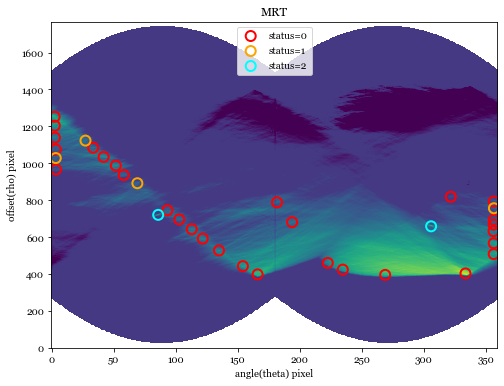

In [30]:
s2.filter_sources(plot=False)
s2.plot_mrt(show_sources=True)

Let's re-plot the MRT with sources to see what made it through

<AxesSubplot:title={'center':'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

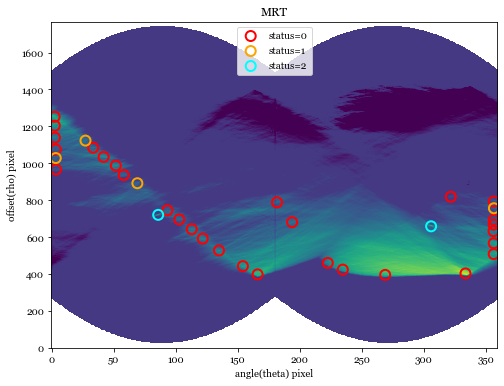

In [31]:
s2.plot_mrt(show_sources=True)

That seems to have worked! Let's make the map to confirm

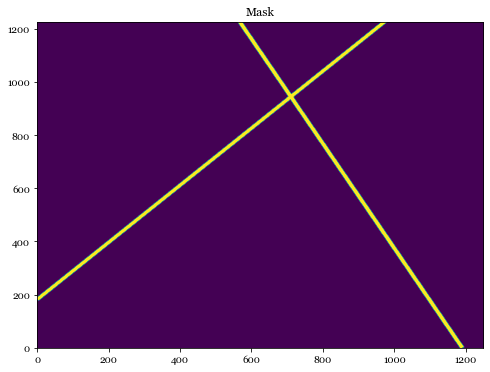

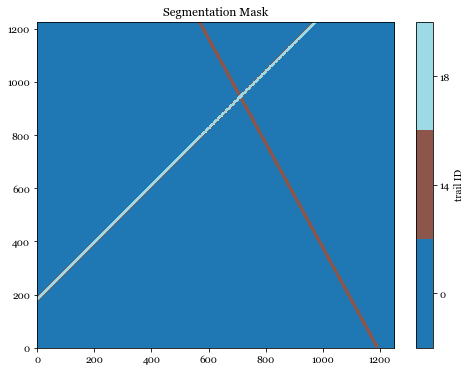

In [32]:
s2.make_mask()
s2.plot_mask()
s2.plot_segment()

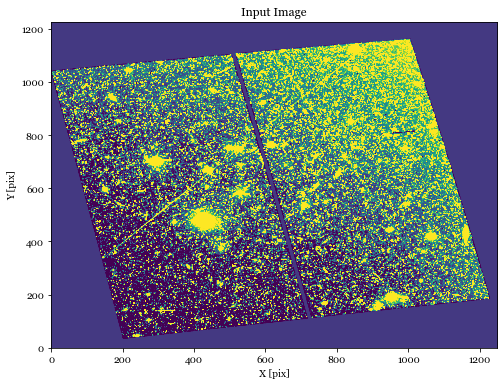

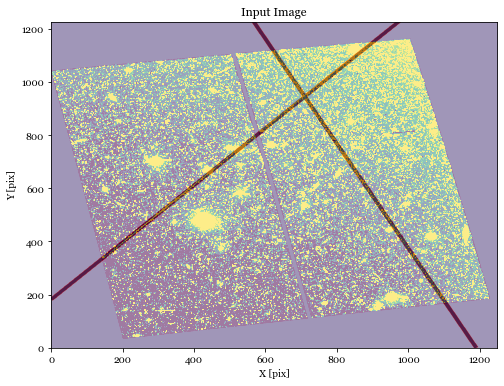

In [33]:
#Let's make a version plotting the mask on top
s2.plot_image()
s2.plot_image(overlay_mask=True)

<a id="example3"></a>
## Example 3:  Quick run on a DRC image

Many of the steps can be run simultaneously once trailfinder is set up. Here's an example of how to do that one the DRC files we loaded early. This example assumes you've loaded and pre-processed the data as in Example 2.

Set up trailfinder the same as above.

In [34]:
s3=trailfinder(image=image_rebin,output_root='flc_quicktest',threads=8)

Then run everything at once and plot the results

In [35]:
s3.run_all()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 threads
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/

(360, 2, 1768)


/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:324: RuntimeWarning: invalid value encountered in true_divide
  return moments / self.moments[:, 0, 0][:, np.newaxis, np.newaxis]
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:315: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(self.flux)
INFO:findsat_mrt:33 sources found
INFO:findsat_mrt:Using kernel /Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width7.fits
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:324: RuntimeWarning: invalid value encountered in true_divide
  return moments / self.moments[:, 0, 0][:, np.newaxis, np.newaxis]
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:315: RuntimeWarning: divide by 

INFO:utils_findsat_mrt:Checking persistence, step 7 of 13
INFO:utils_findsat_mrt:amplitude of feature: 124.71128062390716
INFO:utils_findsat_mrt:baseline noise: 19.113227121294123
INFO:utils_findsat_mrt:snr of feature = 5.5248678222928564
INFO:utils_findsat_mrt:width of feature = 11.554259252619659
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 5.5248678222928564, 11.554259252619659, 249.95628115157066
INFO:utils_findsat_mrt:Checking persistence, step 8 of 13
INFO:utils_findsat_mrt:amplitude of feature: 104.81027053070684
INFO:utils_findsat_mrt:baseline noise: 15.146092645482447
INFO:utils_findsat_mrt:snr of feature = 5.919954405664362
INFO:utils_findsat_mrt:width of feature = 11.151482958021916
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 5.919954405664362, 11.151482958021916, 249.6072440723795
INFO:utils_findsat_mrt:Checking persistence, step 9 of 13
INFO:utils_findsat_mrt:amplitude of feature: 128.3018326465244
INFO:utils_findsat_mrt:baseline noise: 16.903879809889336
INFO:utils_f

INFO:utils_findsat_mrt:amplitude of feature: 873.6164033486714
INFO:utils_findsat_mrt:baseline noise: 88.20212582952412
INFO:utils_findsat_mrt:snr of feature = 8.904709156751906
INFO:utils_findsat_mrt:width of feature = 5.525742638563258
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 8.904709156751906, 5.525742638563258, 250.2882346844635
INFO:utils_findsat_mrt:Checking persistence, step 7 of 14
INFO:utils_findsat_mrt:amplitude of feature: 781.0627121606053
INFO:utils_findsat_mrt:baseline noise: 23.663686630973235
INFO:utils_findsat_mrt:snr of feature = 32.00680592762236
INFO:utils_findsat_mrt:width of feature = 4.007825956164822
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 32.00680592762236, 4.007825956164822, 250.86998067209035
INFO:utils_findsat_mrt:Checking persistence, step 8 of 14
INFO:utils_findsat_mrt:amplitude of feature: 634.790395367999
INFO:utils_findsat_mrt:baseline noise: 24.26158425697513
INFO:utils_findsat_mrt:snr of feature = 25.16442474013208
INFO:utils_findsat_mrt:

INFO:utils_findsat_mrt:baseline noise: 0.0
INFO:utils_findsat_mrt:snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 37.3156986421628
INFO:utils_findsat_mrt:Chunk snr, width ,mean: nan, 37.3156986421628, 252.69902252254784
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 2 of 14
INFO:utils_findsat_mrt:amplitude of feature: 91.68975889027695
INFO:utils_findsat_mrt:baseline noise: 50.38434887017602
INFO:utils_findsat_mrt:snr of feature = 0.819806367380701
INFO:utils_findsat_mrt:width of feature = 16.987849207635463
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 0.819806367380701, 16.987849207635463, 256.12804775846365
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 3 of 14
INFO:utils_findsat_mrt:amplitude of feature: 50.19647832792742
INFO:utils_findsat_mrt:baseline noise: 29.304212105790757
INFO:utils_findsat_mrt:snr of feature = 0.7129441374063826
INFO:ut

INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 2 of 3
INFO:utils_findsat_mrt:amplitude of feature: 16.23848581762377
INFO:utils_findsat_mrt:baseline noise: 9.815736045608878
INFO:utils_findsat_mrt:snr of feature = 0.6543319565819155
INFO:utils_findsat_mrt:width of feature = 29.200918466690894
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 0.6543319565819155, 29.200918466690894, 244.47995607885363
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 3 of 3
INFO:utils_findsat_mrt:amplitude of feature: 15.894564491426976
INFO:utils_findsat_mrt:baseline noise: 11.549738049892929
INFO:utils_findsat_mrt:snr of feature = 0.37618398120936836
INFO:utils_findsat_mrt:width of feature = 16.997420392255265
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 0.37618398120936836, 16.997420392255265, 245.77177242075786
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_fi

<AxesSubplot:title={'center':'Mask'}>

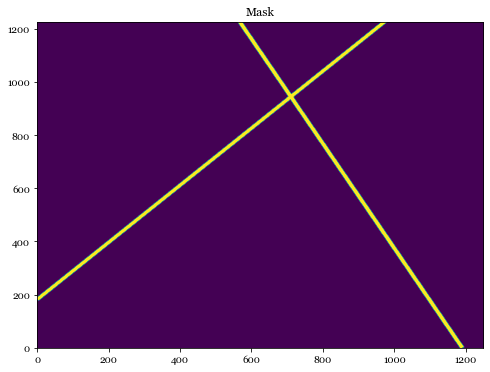

In [36]:
s3.plot_mask()

<a id="about_ID"></a>
### About this Notebook
**Author:** David V. Stark, ACS Instrument Team <br>
**Updated On:** 12/06/2022